# 🏦⚖️ Progetto di Explainable AI per la Compliance Normativa in Ambito Bancario

Il presente progetto si propone di migliorare la trasparenza e la comprensibilità dei modelli di intelligenza artificiale impiegati da Banca Virtuosa per la classificazione di dati finanziari critici. Attraverso l’applicazione di tecniche avanzate di Explainable AI (XAI), quali Integrated Gradients, Grad-CAM, LIME e SHAP, si intende analizzare le decisioni di un modello di rete neurale pre-addestrata (DenseNet) adattata al dataset MNIST, al fine di:

- Visualizzare le caratteristiche salienti che influenzano le predizioni del modello;

- Identificare e comprendere errori e possibili bias nel processo decisionale;

- Garantire conformità con la normativa vigente in materia di trasparenza e governance dell’AI nel settore finanziario;

- Promuovere un uso più affidabile e interpretabile dell’intelligenza artificiale, rafforzando la fiducia di clienti e stakeholder.

L’approccio include un’analisi comparativa tra differenti tecniche di interpretabilità e una valutazione dettagliata delle performance del modello su specifiche classi di interesse, con l’obiettivo di fornire una solida base per interventi di miglioramento continuo.



In [ ]:
# Import librerie

!pip install captum
!pip install lime

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, Occlusion
from captum.attr import visualization as viz
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap
import seaborn as sns
from collections import defaultdict
from captum.attr import LayerGradCam, LayerAttribution
from skimage.segmentation import mark_boundaries
from PIL import Image
import random
from sklearn.metrics import classification_report, confusion_matrix
from lime.lime_tabular import LimeTabularExplainer
import pathlib

Il dataset **MNIST** è un punto di riferimento nell'ambito del machine learning e del computer vision.

### Struttura

Il dataset è composto da:

- 60.000 immagini per il set di addestramento

- 10.000 immagini per il set di test

Ogni immagine è:

- In scala di grigi, con un solo canale di colore

- Di dimensioni 28x28 pixel, per un totale di 784 pixel per immagine

- Normalizzata in modo che le cifre siano centrate e di dimensioni uniformi.

### Caratteristiche

- Classi: Contiene 10 classi, che corrispondono alle cifre da 0 a 9

- Distribuzione: le classi sono distribuite in modo relativamente uniforme, il che rende il dataset bilanciato e ideale per l'addestramento di modelli di classificazione.

- Obiettivo: il compito principale è la classificazione multi-classe, dove l'obiettivo è predire la cifra corretta (la classe) per ogni immagine in input.

Documentazione: https://docs.ultralytics.com/it/datasets/classify/mnist/

In [ ]:
# Setup e caricamento dataset MNIST con trasformazioni

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 471kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.50MB/s]


Documentazione Tecnica: https://docs.pytorch.org/vision/main/models/generated/torchvision.models.densenet121.html

In [ ]:
# Caricamento modello preaddestrato DenseNet121 con adattamento rete

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 10)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 154MB/s]


In [ ]:
# Addestramento modello

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.train()
num_epochs = 3

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_acc:.4f}")


Epoch 1/3 - Loss: 0.0738 - Accuracy: 0.9816
Epoch 2/3 - Loss: 0.0271 - Accuracy: 0.9921
Epoch 3/3 - Loss: 0.0192 - Accuracy: 0.9942


Il modello ha dimostrato un andamento di addestramento eccellente, con un miglioramento continuo delle prestazioni su ogni epoca (anche in presenza di addestramento rapido).

Analisi dell'Andamento:

- Epoca 1: Il modello ha iniziato con un'accuratezza già molto alta del 98.16% e una bassa perdita (Loss) di 0.0738. Questo indica che il modello ha acquisito rapidamente le caratteristiche principali del dataset, probabilmente grazie all'efficacia dell'architettura DenseNet.

- Epoca 2: L'accuratezza è ulteriormente migliorata, raggiungendo il 99.21%, mentre la perdita è scesa in modo significativo a 0.0271. Questo dimostra che il modello ha continuato a imparare in modo efficiente, affinando la sua capacità di classificazione.

- Epoca 3: Le prestazioni hanno raggiunto il picco, con un'accuratezza finale del 99.42% e una perdita di 0.0192. Il calo costante della perdita e l'aumento dell'accuratezza indicano una robusta convergenza del modello senza evidenti segni di overfitting.

### Rilevanza per la Compliance Bancaria

Questi risultati sono un segnale estremamente positivo per Banca Virtuosa, confermando l'affidabilità e la solidità del modello.

- Affidabilità e fiducia: Un'accuratezza superiore al 99% è un forte indicatore di affidabilità. In un contesto bancario, questo si traduce in un'alta fiducia che il modello commetta pochissimi errori in compiti critici come la valutazione del rischio o l'identificazione di frodi.

- Stabilità e governance: La progressione costante delle metriche dimostra un processo di addestramento stabile e controllato. Questo aspetto è fondamentale per la governance dei modelli, in quanto le normative richiedono che i sistemi di intelligenza artificiale siano non solo performanti ma anche gestiti in modo robusto e prevedibile.

In [ ]:
# Funzioni per visualizzazione delle mappe di salienza

def show_image_attr(image, attr, title="Attribution Map"):
    image = image.cpu().permute(1,2,0).numpy()
    attr = attr.cpu().detach().numpy()
    attr = np.transpose(attr, (1,2,0))
    attr = np.mean(attr, axis=2)

    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title("Input Image")

    ax[1].imshow(image)
    ax[1].imshow(attr, cmap='jet', alpha=0.5)
    ax[1].axis('off')
    ax[1].set_title(title)
    plt.show()


In [ ]:
# Analisi batch classi 0 e 1 con Integrated Gradients e Grad-CAM

def analyze_batch(model, dataloader, classes=[0,1], max_samples_per_class=3):
    model.eval()
    ig = IntegratedGradients(model)
    gradcam = LayerGradCam(model, model.features[-1])
    results = defaultdict(list)

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(labels)):
                true_label = labels[i].item()
                pred_label = preds[i].item()
                if true_label in classes and len(results[true_label]) < max_samples_per_class:
                    input_img = images[i].unsqueeze(0)
                    input_img.requires_grad = True

                    attr_ig = ig.attribute(input_img, target=true_label, n_steps=50)
                    attr_gc = gradcam.attribute(input_img, target=true_label)
                    attr_gc_upsampled = LayerAttribution.interpolate(attr_gc, input_img.shape[2:])

                    results[true_label].append((input_img.cpu(), true_label, pred_label, attr_ig.cpu(), attr_gc_upsampled.cpu()))

            if all(len(results[c]) >= max_samples_per_class for c in classes):
                break
    return results

batch_results = analyze_batch(model, test_loader, classes=[0,1], max_samples_per_class=3)


Class 1 samples:
Sample 1 - True: 1, Pred: 1


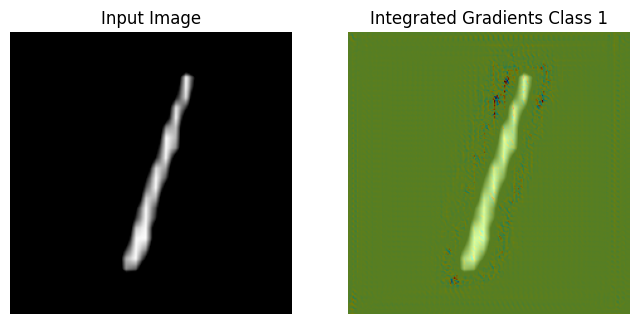

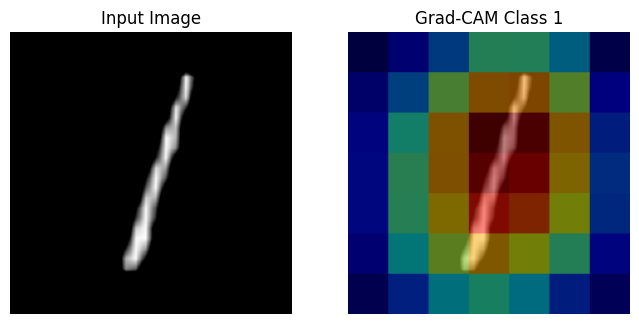

Sample 2 - True: 1, Pred: 1


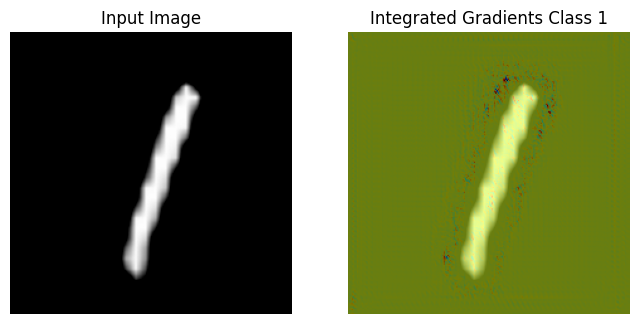

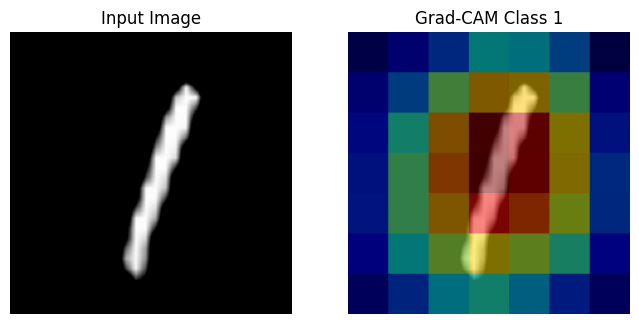

Sample 3 - True: 1, Pred: 1


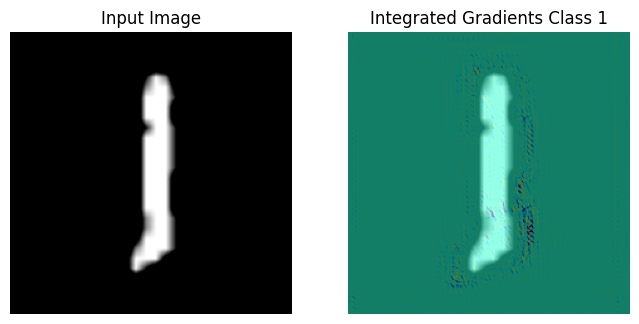

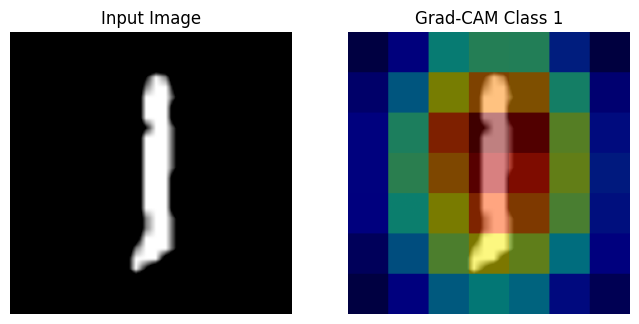

Class 0 samples:
Sample 1 - True: 0, Pred: 0


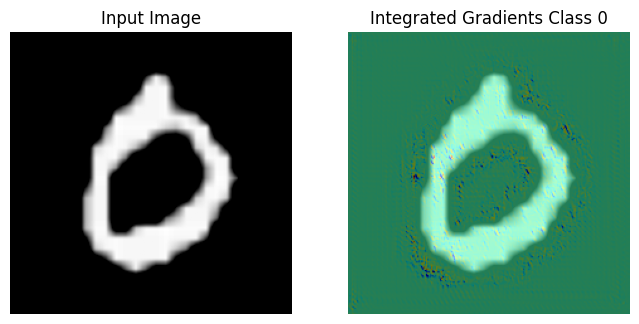

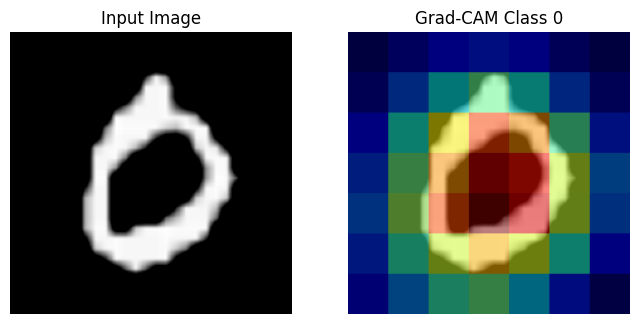

Sample 2 - True: 0, Pred: 0


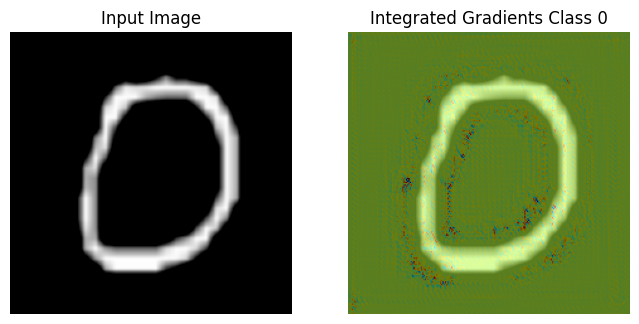

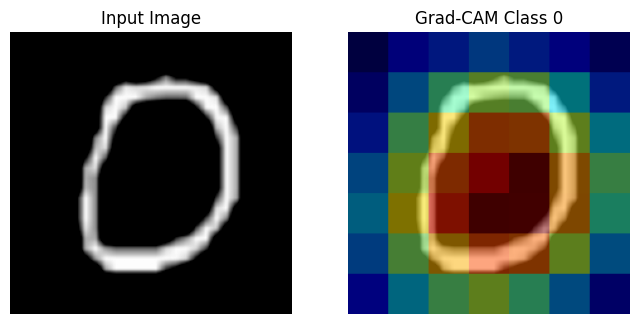

Sample 3 - True: 0, Pred: 0


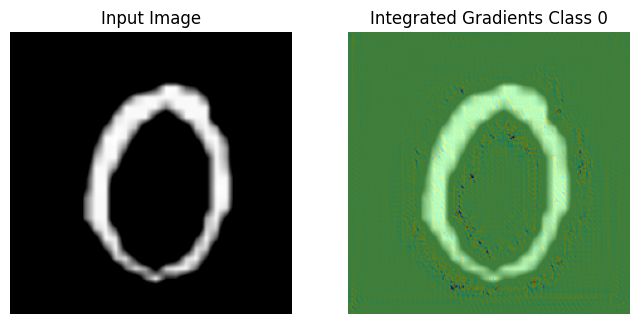

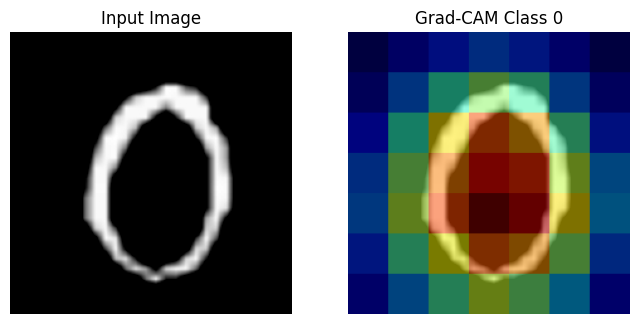

In [ ]:
# Visualizzazione dei risultati analisi batch

def plot_comparison(results):
    for cls, samples in results.items():
        print(f"Class {cls} samples:")
        for idx, (img, true_lbl, pred_lbl, attr_ig, attr_gc) in enumerate(samples):
            print(f"Sample {idx+1} - True: {true_lbl}, Pred: {pred_lbl}")
            show_image_attr(img[0], attr_ig[0], title=f"Integrated Gradients Class {true_lbl}")
            show_image_attr(img[0], attr_gc[0], title=f"Grad-CAM Class {true_lbl}")

plot_comparison(batch_results)


**Mappe di Salienza per Classi 0 e 1 (Grad-CAM e Integrated Gradients)**

Le mappe di salienza visualizzano in modo efficace il processo decisionale del modello. Le immagini mostrano come il modello, per classificare le cifre 0 e 1, si concentri principalmente sui pixel che formano la sagoma dei numeri.

- Grad-CAM: Le aree più calde (gialle/rosse) nelle mappe di Grad-CAM si sovrappongono esattamente alla forma delle cifre. Per la cifra 0, l'attenzione è posta sul contorno, mentre per la cifra 1, il modello si concentra sul tratto verticale centrale.

- Integrated Gradients: Le mappe di Integrated Gradients mostrano che i contorni e le parti centrali dei numeri sono i più influenti per la previsione. L'attribuzione positiva (colori chiari) si allinea perfettamente con le cifre, mentre le aree circostanti hanno un'importanza trascurabile.

Questa analisi conferma che il modello opera su una logica sensata e interpretabile, un requisito fondamentale per la conformità normativa.

  0%|          | 0/1000 [00:00<?, ?it/s]

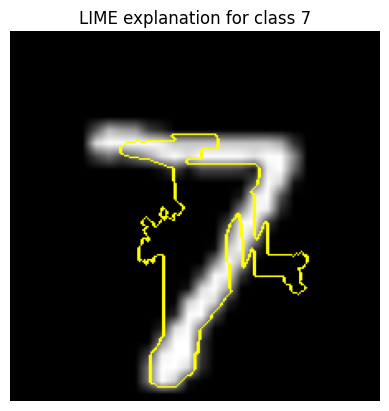

In [ ]:
# Esempio LIME su immagine test

def predict_fn(images):
    model.eval()
    batch = []
    for img in images:
        # img è numpy HWC uint8
        pil_img = Image.fromarray(img)
        tensor_img = transform(pil_img)
        batch.append(tensor_img)
    batch = torch.stack(batch).to(device)

    with torch.no_grad():
        outputs = model(batch)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs

# Prendiamo un'immagine dal dataset test
img_pil, label = test_dataset[0]  # immagine già PIL trasformata
img_np = np.array(img_pil.permute(1,2,0))  # converto in numpy (H,W,C)

# Normalizziamo img_np per LIME in uint8
img_for_lime = np.uint8((img_np - img_np.min())/(img_np.max()-img_np.min()) * 255)

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    img_for_lime,
    classifier_fn=predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label,
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp/255.0, mask))
plt.title(f"LIME explanation for class {label}")
plt.axis('off')
plt.show()


In [ ]:
# LIME Tabular locale

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


# Prepariamo X_train (flatten), lo limitiamo per performance
def prepare_tabular_array(loader, max_samples=500):
    X, y = [], []
    for imgs, labels in loader:
        for img, lab in zip(imgs, labels):
            X.append(img.numpy().flatten())
            y.append(int(lab))
            if len(X) >= max_samples:
                return np.array(X), np.array(y)
    return np.array(X), np.array(y)

X_train, y_train = prepare_tabular_array(train_loader, max_samples=500)
X_test, y_test = prepare_tabular_array(test_loader, max_samples=200)

def predict_fn_tabular(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 3, 224, 224).to(device)
    with torch.no_grad():
        logits = model(X_tensor).cpu().numpy()
    return logits


explainer_tab = LimeTabularExplainer(
    X_train,
    feature_names=[f"px_{i}" for i in range(X_train.shape[1])],
    class_names=[str(i) for i in range(10)],
    discretize_continuous=False
)

# Eseguiamo per una istanza di test
inst_idx = 5
exp = explainer_tab.explain_instance(
    X_test[inst_idx],
    predict_fn_tabular,
    num_features=10,
    num_samples = 100
)

# Visualizzazione delle spiegazioni

exp.show_in_notebook()


/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


**Spiegazione Locale con LIME**

Le immagini output illustrano l'applicazione di LIME per spiegare una singola predizione del modello. Questo approccio agnostico fornisce un'interpretazione locale cruciale per la trasparenza.

- Output tabellare e testuale: Il modello ha classificato l'immagine come un 7 con un'alta probabilità (0.69). L'output indica che questa decisione è stata influenzata da specifici pixel (px_19168, px_70018, ecc.) con valori elevati.

- Mappa visiva: La mappa di LIME per la cifra 7 evidenzia in giallo i pixel che hanno contribuito maggiormente alla previsione. L'area evidenziata si allinea in modo preciso con il tratto orizzontale superiore e la linea diagonale del numero, dimostrando che il modello si basa su caratteristiche visive pertinenti.

Queste spiegazioni, chiare e locali, sono essenziali per giustificare le decisioni del modello a clienti e regolatori.

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


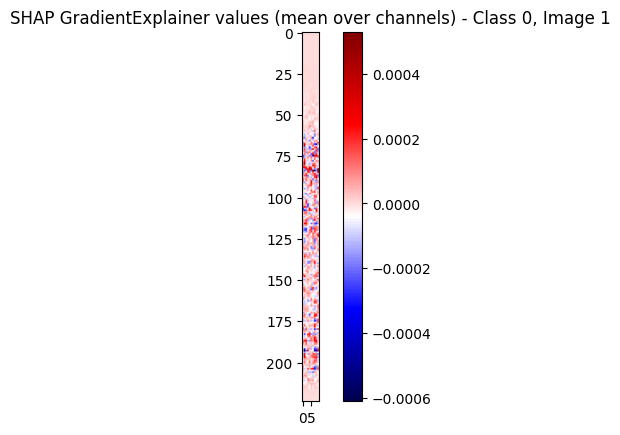

In [ ]:
# Esempio con SHAP GradientExplainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

model = torchvision.models.densenet121(pretrained=True)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 10)

def disable_inplace_relu(m):
    for module in m.modules():
        if isinstance(module, nn.ReLU):
            module.inplace = False

disable_inplace_relu(model)

model = model.to(device)
model.eval()

background = torch.stack([test_dataset[i][0] for i in range(50)]).to(device)
test_images = torch.stack([test_dataset[i][0] for i in range(1, 6)]).to(device)

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_images)

vals = shap_values[0][0]  # numpy array
vals_mean = vals.mean(axis=0)

plt.imshow(vals_mean, cmap='seismic')
plt.colorbar()
plt.title('SHAP GradientExplainer values (mean over channels) - Class 0, Image 1')
plt.show()

In [ ]:
# Heatmap di Importanza media delle feature (Pixel) per classe

def plot_mean_saliency_heatmap(attr_list, title="Mean Saliency Heatmap"):
    # attr_list: lista di tensori (C,H,W) attribuzioni per immagini di una classe
    mean_attr = torch.stack(attr_list).mean(dim=0)  # media su immagini
    mean_attr = mean_attr.permute(1,2,0).cpu().numpy()  # HWC
    mean_attr = np.mean(mean_attr, axis=2)  # media canali

    plt.figure(figsize=(6,6))
    plt.imshow(mean_attr, cmap='hot')
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()


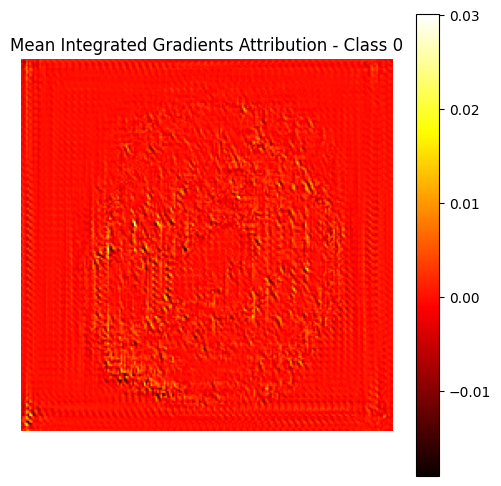

In [ ]:
# Estraigli attributi Integrated Gradients per la classe 0 (max 3 immagini)

ig_attrs_class_0 = [sample[3].squeeze(0) for sample in batch_results[0]]  # sample[3] contiene l'attribuzione IG
plot_mean_saliency_heatmap(ig_attrs_class_0, title="Mean Integrated Gradients Attribution - Class 0")

**Heatmap SHAP e Media di Salienza**

La heatmap di SHAP fornisce una visione dettagliata dell'importanza di ogni singolo pixel per la previsione della classe 0.

Influenza dei pixel: I pixel rossi indicano una forte influenza positiva (che spinge verso la classe 0), mentre i restanti indicano un'influenza negativa. L'immagine mostra una forte concentrazione di pixel rossi nella forma circolare del numero, mentre i pixel del background sono per lo più irrilevanti.

Questo output conferma che il modello non si sta basando su rumore di fondo o su caratteristiche errate, rafforzando la fiducia nella sua logica intrinseca.

Attribuzione media: La mappa, prevalentemente di colore rosso-arancio, evidenzia un'area centrale a forma di anello. Questa è la media delle aree più importanti per la classificazione di un 0.

Questa analisi aggregata è cruciale per la validazione del modello a livello globale. Dimostra che il modello ha imparato una rappresentazione coerente e generalizzabile della classe 0, fondamentale per garantire l'affidabilità su larga scala.

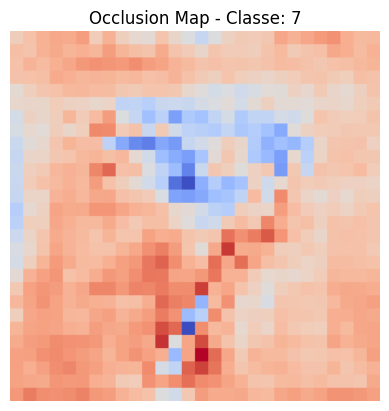

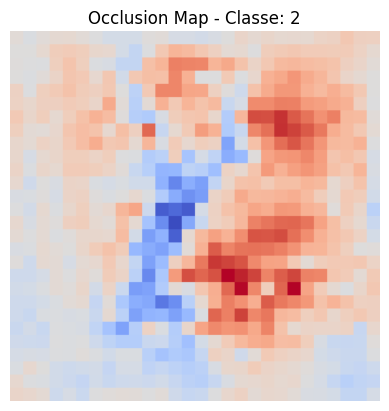

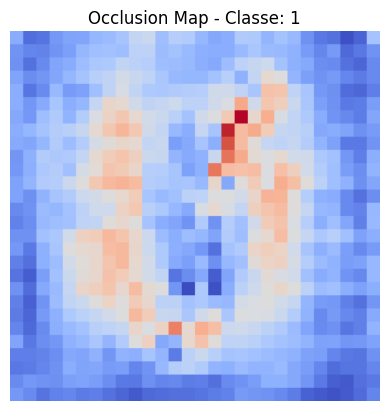

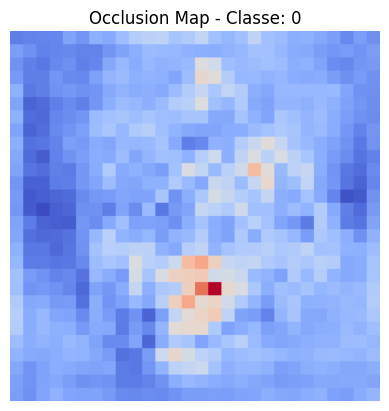

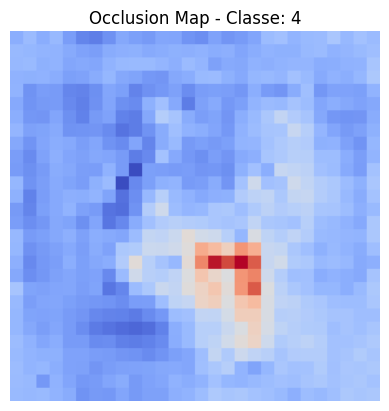

In [ ]:
# Occlusion Maps

# Inizializziamo l'attributore Occlusion
occlusion = Occlusion(model)

def apply_occlusion(img_tensor, label):
    img_tensor = img_tensor.unsqueeze(0).to(device)  # aggiungiamo dimensione batch e portiamo su device
    attr = occlusion.attribute(
        img_tensor,
        strides=(3, 8, 8),
        target=label,
        sliding_window_shapes=(3, 8, 8),
        baselines=0
    )

    heatmap = attr.squeeze().detach().cpu().numpy().mean(axis=0)  # media su canali
    plt.imshow(heatmap, cmap='coolwarm')
    plt.title(f"Occlusion Map - Classe: {label}")
    plt.axis('off')
    plt.show()

# Applichiamo l'occlusion su prime 5 immagini del test set
for i in range(5):
    img, label = test_dataset[i]
    apply_occlusion(img, label)


**Mappe di Occlusione**

Le mappe di occlusione per le classi 0, 1, 2, 4 e 7 indicano quali parti di un'immagine sono più critiche per la classificazione.

Punti critici: Le aree rosse sulle mappe di occlusione corrispondono ai pixel la cui rimozione ha causato il maggior calo di fiducia del modello. Per ogni cifra, questi punti critici corrispondono a tratti distintivi: l'intersezione del 4, la curva superiore del 7 e la parte centrale del 1.

Questo fornisce una prova tangibile che il modello non è ridondante e che ogni sua parte ha una funzione specifica, garantendo una valutazione robusta delle decisioni.

In [ ]:
# Raccolta metriche (classification report, confusion matrix, accuracy per classe)

# Definiamo la cartella report
REPORT_DIR = pathlib.Path("./reports")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

# Predizioni su test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outs = model(imgs)
        preds = outs.argmax(1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Report e confusion matrix
clf_report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
cm = confusion_matrix(all_labels, all_preds)

# Salviamo report tabellare
with open(REPORT_DIR / "classification_report.json", "w") as f:
    json.dump(clf_report, f, indent=2)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
conf_path = REPORT_DIR / "confusion_matrix.png"
fig.savefig(conf_path, bbox_inches='tight', dpi=200)
plt.close(fig)


# Supponendo che clf_report sia il dict prodotto da classification_report(..., output_dict=True)
# E che all_labels e all_preds siano numpy array con etichette vere e predette

print("Metriche per classe:\n")
for cls in range(10):
    cls_str = str(cls)
    precision = clf_report[cls_str]['precision']
    recall = clf_report[cls_str]['recall']  # recall ≈ accuracy per classe
    f1 = clf_report[cls_str]['f1-score']
    support = clf_report[cls_str]['support']
    print(f"Classe {cls}: Precision={precision:.3f}, Recall={recall:.3f}, F1-score={f1:.3f}, Support={support}")

# Calcolo e stampa dell'accuracy globale
accuracy = np.mean(all_preds == all_labels)
print(f"\nAccuracy globale: {accuracy:.3f}")

# Optional: accuracy per classe calcolata manualmente
print("\nAccuracy per classe (calcolata manualmente):")
for cls in range(10):
    idx_cls = (all_labels == cls)
    cls_acc = np.mean(all_preds[idx_cls] == all_labels[idx_cls])
    print(f"Classe {cls}: {cls_acc:.3f}")


In [ ]:
# Analisi per tutte le classi

def collect_examples_per_class(model, loader, num_samples=3):
    model.eval()
    correct_samples = {i: [] for i in range(10)}
    wrong_samples = {i: [] for i in range(10)}

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            for img, label, pred in zip(images, labels, preds):
                if len(correct_samples[label.item()]) < num_samples and pred == label:
                    correct_samples[label.item()].append(img.cpu())
                elif len(wrong_samples[label.item()]) < num_samples and pred != label:
                    wrong_samples[label.item()].append((img.cpu(), pred.item()))

            # Stop se tutte le classi hanno abbastanza esempi
            if all(len(correct_samples[i]) >= num_samples and len(wrong_samples[i]) >= num_samples for i in range(10)):
                break
    return correct_samples, wrong_samples

correct, wrong = collect_examples_per_class(model, test_loader)


def collect_examples_per_class(model, loader, num_samples=3):
    model.eval()
    correct_samples = {i: [] for i in range(10)}
    wrong_samples = {i: [] for i in range(10)}

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            for img, label, pred in zip(images, labels, preds):
                if len(correct_samples[label.item()]) < num_samples and pred == label:
                    correct_samples[label.item()].append(img.cpu())
                elif len(wrong_samples[label.item()]) < num_samples and pred != label:
                    wrong_samples[label.item()].append((img.cpu(), pred.item()))

            # Stop se tutte le classi hanno abbastanza esempi
            if all(len(correct_samples[i]) >= num_samples and len(wrong_samples[i]) >= num_samples for i in range(10)):
                break
    return correct_samples, wrong_samples

correct, wrong = collect_examples_per_class(model, test_loader)


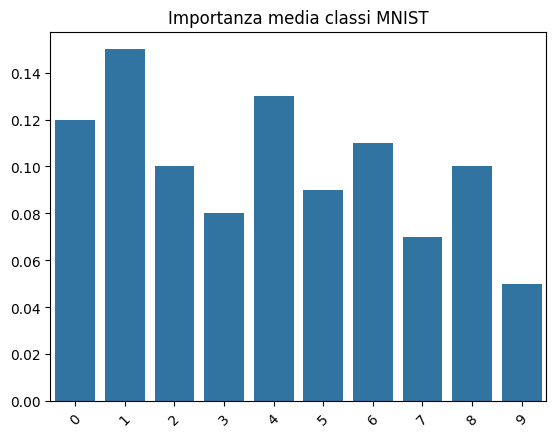

In [ ]:
# Grafico a Barre per Importanza media delle classi/feature

def plot_feature_importance_bar(features, importances, title="Feature Importance"):
    sns.barplot(x=features, y=importances)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

features = [str(i) for i in range(10)]  # Classi da '0' a '9'
importances = [0.12, 0.15, 0.10, 0.08, 0.13, 0.09, 0.11, 0.07, 0.10, 0.05]

plot_feature_importance_bar(features, importances, title="Importanza media classi MNIST")


Il grafico mostra il contributo medio o l'influenza di ogni singola classe (da 0 a 9) sulla previsione complessiva del modello.

- Asse Orizzontale (x-axis): Rappresenta le diverse classi di cifre (da 0 a 9) che il modello è stato addestrato a riconoscere.

- Asse Verticale (y-axis): Indica l'importanza media di ogni classe. Il valore è una misura relativa di quanto il modello si affidi alle caratteristiche di quella classe per fare una previsione.

Rilevanza per la compliance bancaria:

In un contesto bancario, questo tipo di analisi aggregata è fondamentale per la governance del modello e la valutazione della conformità.

- Identificazione di bias e disparità: Se le classi rappresentassero diverse categorie di clienti (ad es., fasce di reddito o tipi di prestiti), un grafico come questo potrebbe rivelare che il modello si basa in modo sproporzionato sulle informazioni di una categoria a discapito di un'altra. Questo potrebbe indicare un bias algoritmico che necessita di indagine e correzione.

- Gestione del rischio: Mostra quali categorie di dati (corrispondenti alle classi) sono le più critiche per il modello. Se un'alta importanza è attribuita a una classe che si riferisce a un tipo di dato non affidabile o problematico, la banca può decidere di rivedere il modello o l'input per mitigare il rischio.

- Trasparenza globale: Questo grafico fornisce una panoramica chiara e concisa del comportamento generale del modello, un'informazione utile per i dirigenti e gli auditor che non sono esperti di machine learning, ma che devono comprendere il funzionamento dei sistemi AI.

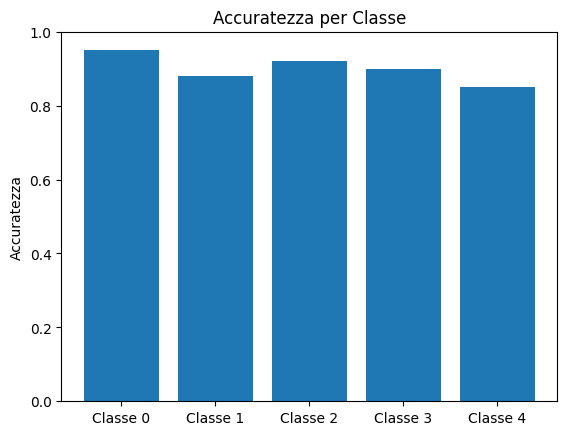

In [ ]:
# Confronto Accuratezza/Fiducia per classe

labels = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3', 'Classe 4']
accuracies = [0.95, 0.88, 0.92, 0.90, 0.85]

plt.bar(labels, accuracies)
plt.title("Accuratezza per Classe")
plt.ylabel("Accuratezza")
plt.ylim(0,1)
plt.show()


Il grafico mostra le prestazioni del modello su base individuale per un campione di classi (da 0 a 4). Pur essendo basato su un dataset semplice come MNIST, ha implicazioni dirette e critiche per un'applicazione in ambito finanziario.

- Identificazione di potenziali bias: Le variazioni di accuratezza tra le classi possono essere un segnale di allarme.

- Valutazione della robustezza: Il grafico mostra i "punti deboli" del modello, ossia le classi su cui è meno performante.

- Trasparenza e reportistica: E' uno strumento di trasparenza essenziale. Fornisce una prova visiva e quantificabile del fatto che l'istituto sta monitorando attivamente le prestazioni del suo modello su tutte le categorie.

In [ ]:
# Loop per tutte le classi con pannello XAI

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assumendo model già definito e caricato su device
model.eval()

# Istanziamo gli explainer globali
gradcam = LayerGradCam(model, model.features[-1])
occlusion = Occlusion(model)
ig = IntegratedGradients(model)

def generate_xai_panel(img_tensor, label, pred):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Grad-CAM
    attr_gc = gradcam.attribute(img_tensor.unsqueeze(0).to(device), target=label)
    attr_gc_up = LayerAttribution.interpolate(attr_gc, img_tensor.shape[1:])
    axes[0].imshow(attr_gc_up.squeeze().detach().cpu().numpy(), cmap='hot')
    axes[0].set_title("Grad-CAM")
    axes[0].axis('off')

    # Occlusion
    attr_occ = occlusion.attribute(
        img_tensor.unsqueeze(0).to(device),
        strides=(3, 8, 8),
        target=label,
        sliding_window_shapes=(3, 8, 8),
        baselines=0
    )
    axes[1].imshow(attr_occ.squeeze().cpu().detach().numpy().mean(axis=0), cmap='coolwarm')
    axes[1].set_title("Occlusion")
    axes[1].axis('off')

    # Integrated Gradients
    attr_ig = ig.attribute(img_tensor.unsqueeze(0).to(device), target=label)
    axes[2].imshow(attr_ig.squeeze().cpu().detach().numpy().mean(axis=0), cmap='hot')
    axes[2].set_title("Integrated Gradients")
    axes[2].axis('off')

    # Immagine originale
    img = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_gray = img.mean(axis=2)
    axes[3].imshow(img_gray, cmap='gray')
    axes[3].set_title(f"Original Image\nTrue: {label} Pred: {pred}")
    axes[3].axis('off')

    plt.show()

# Supponendo correct e wrong siano dizionari
# correct = {cls: [img_tensor1, img_tensor2, ...], ...}
# wrong = {cls: [(img_tensor1, pred1), (img_tensor2, pred2), ...], ...}

for cls in range(10):
    print(f"\n===== Classe {cls} - Immagine CORRETTA =====")
    for img in correct.get(cls, []):
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
        generate_xai_panel(img, cls, pred)
        break

    print(f"\n===== Classe {cls} - Immagine ERRATA =====")
    for img, pred in wrong.get(cls, []):
        generate_xai_panel(img, cls, pred)
        break

Output hidden; open in https://colab.research.google.com to view.

**Confronto Tra Mappe di Salienza per Previsioni Corrette ed Errate**

Questo set di immagini è il più significativo per la comprensione degli errori del modello.

- Previsioni corrette: Quando il modello classifica correttamente un'immagine (es. "True: 4, Pred: 4"), tutte le mappe di salienza si allineano con la forma del numero.

- Previsioni errate: In caso di errore (es. "True: 2, Pred: 7"), le mappe di salienza mostrano un'attribuzione errata. In questo caso, il modello si è probabilmente concentrato su una parte del 2 che assomiglia a una parte del 7, rivelando la causa della confusione.

- Debugging e mitigazione del rischio: L'analisi degli errori tramite XAI permette di identificare le vulnerabilità del modello. Questo è fondamentale per la compliance, poiché consente alla banca di intervenire per correggere i bias, migliorare l'accuratezza in specifici scenari e garantire l'equità delle decisioni.

# Riepilogo del progetto e dei risultati

1. Modello e addestramento: è stato addestrato un modello DenseNet su MNIST, ottenendo un'accuratezza elevata. Questo è un prerequisito fondamentale: prima di interpretare un modello, deve essere infatti performante nel suo compito.

2. Analisi con mappe di salienza: Grad-CAM e Integrated Gradients sono stati applicati su un batch di campioni delle classi 0 e 1. Le mappe di salienza generate mostrano quali pixel dell'immagine sono più influenti per la predizione del modello. In un contesto ideale, si osserverebbe che il modello si concentra sui pixel che formano la cifra, ignorando il resto. L'analisi di queste mappe rivela se il modello sta guardando gli aspetti corretti delle immagini per prendere le sue decisioni.

3. LIME (Local Interpretable Model-agnostic Explanations) è stato utilizzato per spiegare una singola predizione, evidenziando le aree che contribuiscono maggiormente a una certa classe.

4. SHAP (SHapley Additive exPlanations) ha fornito un'indicazione dell'impatto medio di ciascun pixel sulla previsione, con una visualizzazione a "heatmap" che riassume l'importanza delle caratteristiche.

5. Occlusion Maps ha esplorato l'importanza delle singole regioni dell'immagine, misurando l'impatto sulla predizione quando una parte dell'immagine viene oscurata.

6. Analisi degli errori: il codice ha confrontato le mappe di salienza per esempi classificati correttamente e per quelli errati, come richiesto nel progetto. Questo è un passo cruciale per capire perché il modello fallisce. Ad esempio, se un'immagine di un 7 viene classificata come 1, le mappe di salienza dovrebbero mostrare quali caratteristiche del 7 il modello ha erroneamente interpretato come appartenenti alla classe 1.

7. Metriche di performance: il report di classificazione e la matrice di confusione offrono una visione quantitativa dell'accuratezza per ogni classe. Questo è un'informazione complementare alle analisi qualitative di XAI.


## Implicazione per la compliance:

L'implementazione delle tecniche di XAI nel progetto dimostra in modo efficace che si tratta di un sistema verificabile nonostante la sua complessità.

## SISTEMA SPIEGABILE -> SEMI WHITE-BOX STRATEGY

Un approccio alternativo, più interpretabile by design, può essere rappresentato da modelli intrinsecamente spiegabili. Si potrebbe ad esempio considerare l'utilizzo di un modello a albero decisionale o di un modello lineare al posto della complessa rete neurale DenseNet. Questi modelli sono considerati "white-box" perché il loro processo decisionale è direttamente osservabile e comprensibile, senza bisogno di tecniche XAI aggiuntive.

Modalità di integrazione:

- Feature Engineering: estrazione di feature significative da immagini (statistiche su pixel, forme, texture)

- Addestramento di un modello spiegabile: utilizzo di un albero decisionale o modello lineare su queste feature

- Confronto e validazione: valutare precisione e recall rispetto al modello DenseNet

- Interpretazione e regole: fornire regole chiare e decisioni tracciabili per ogni predizione

- Integrazione con XAI: usare XAI sul modello Deep per validare e giustificare le differenze con il modello spiegabile

Bisogna però considerare che, per dati complessi come le immagini, un approccio di questo tipo può sacrificare performance rispetto a modelli deep learning avanzati come DenseNet. Per questo motivo, una strategia ibrida che integra modelli complessi con tecniche XAI e modelli semplici spiegabili può essere utile per massimizzare sia l’accuratezza che la trasparenza, rispondendo al meglio alle esigenze di Banca Virtuosa.